# Job Search

----
#### John Stachurski
#### Prepared for the CBC Computational Workshop (May 2024)

----

Uncomment if necessary

In [33]:
#!pip install quantecon

In this lecture we study a basic infinite-horizon job search problem with Markov wage
draws 

The exercise at the end asks you to add recursive preferences and compare
the result.

We use the following imports.

In [34]:
import matplotlib.pyplot as plt
import quantecon as qe
import jax
import jax.numpy as jnp
from collections import namedtuple

jax.config.update("jax_enable_x64", True)

Let's check our GPU status:

In [4]:
!nvidia-smi

Thu May 16 22:08:09 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080        Off |   00000000:3E:00.0 Off |                  N/A |
| 30%   29C    P8             26W /  320W |       6MiB /  10240MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

/home/john/anaconda3/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Model

We study an elementary model where 

* jobs are permanent 
* unemployed workers receive current compensation $c$
* the wage offer distribution $\{W_t\}$ is Markovian
* the horizon is infinite
* an unemployment agent discounts the future via discount factor $\beta \in (0,1)$

### Set up

The wage offer process obeys

$$
    W_{t+1} = \rho W_t + \nu Z_{t+1}
$$

where $(Z_t)_{t \geq 0}$ is IID and standard normal.

We discretize this wage process using Tauchen's method to produce a stochastic matrix $P$

### Rewards

Since jobs are permanent, the return to accepting wage offer $w$ today is

$$
    w + \beta w + \beta^2 w + \frac{w}{1-\beta}
$$

The Bellman equation is

$$
    v(w) = \max
    \left\{
            \frac{w}{1-\beta}, c + \beta \sum_{w'} v(w') P(w, w')
    \right\}
$$

We solve this model using value function iteration.

## Code

Let's set up a namedtuple to store information needed to solve the model.

In [5]:
Model = namedtuple('Model', ('n', 'w_vals', 'P', 'β', 'c'))

The function below holds default values and populates the namedtuple.

In [6]:
def create_js_model(
        n=500,       # wage grid size
        ρ=0.9,       # wage persistence
        ν=0.2,       # wage volatility
        β=0.99,      # discount factor
        c=1.0,       # unemployment compensation
    ):
    "Creates an instance of the job search model with Markov wages."
    mc = qe.tauchen(n, ρ, ν)
    w_vals, P = jnp.exp(mc.state_values), jnp.array(mc.P)
    return Model(n, w_vals, P, β, c)

Let's test it:

In [7]:
model = create_js_model(β=0.98)

In [8]:
model.c

1.0

In [9]:
model.β

0.98

In [10]:
model.w_vals.mean()  

Array(1.34861482, dtype=float64)

Here's the Bellman operator.

In [11]:
@jax.jit
def T(v, model):
    """
    The Bellman operator Tv = max{e, c + β E v} with 

        e(w) = w / (1-β) and (Ev)(w) = E_w[ v(W')]

    """
    n, w_vals, P, β, c = model
    h = c + β * P @ v
    e = w_vals / (1 - β)

    return jnp.maximum(e, h)

Question: Is this a pure function?

The next function computes the optimal policy under the assumption that $v$ is
                 the value function.

The policy takes the form

$$
    \sigma(w) = \mathbf 1 
        \left\{
            \frac{w}{1-\beta} \geq c + \beta \sum_{w'} v(w') P(w, w')
        \right\}
$$

Here $\mathbf 1$ is an indicator function.

* $\sigma(w) = 1$ means stop
* $\sigma(w) = 0$ means continue.

In [12]:
@jax.jit
def get_greedy(v, model):
    "Get a v-greedy policy."
    n, w_vals, P, β, c = model
    e = w_vals / (1 - β)
    h = c + β * P @ v
    σ = jnp.where(e >= h, 1, 0)
    return σ

Here's a routine for value function iteration.

In [13]:
def vfi(model, max_iter=10_000, tol=1e-4):
    "Solve the infinite-horizon Markov job search model by VFI."
    print("Starting VFI iteration.")
    v = jnp.zeros_like(model.w_vals)    # Initial guess
    i = 0
    error = tol + 1

    while error > tol and i < max_iter:
        new_v = T(v, model)
        error = jnp.max(jnp.abs(new_v - v))
        i += 1
        v = new_v

    v_star = v
    σ_star = get_greedy(v_star, model)
    return v_star, σ_star

Question: Is this a pure function?

## Computing the solution

Let's set up and solve the model.

In [14]:
model = create_js_model()
n, w_vals, P, β, c = model

v_star, σ_star = vfi(model)

Starting VFI iteration.


Here's the optimal policy:

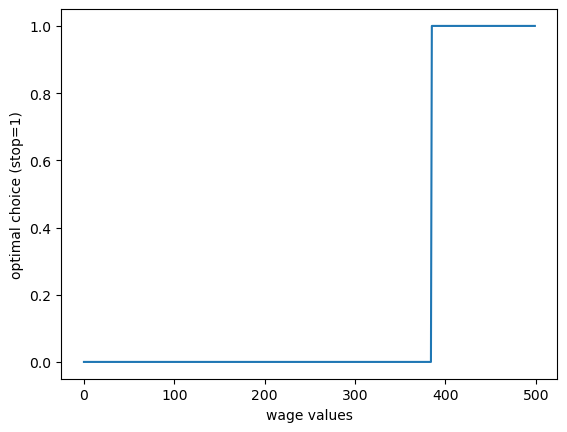

In [15]:
fig, ax = plt.subplots()
ax.plot(σ_star)
ax.set_xlabel("wage values")
ax.set_ylabel("optimal choice (stop=1)")
plt.show()

We compute the reservation wage as the first $w$ such that $\sigma(w)=1$.

In [27]:
stop_indices = jnp.where(σ_star == 1)[0]
stop_indices

Array([385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397,
       398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410,
       411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423,
       424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436,
       437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449,
       450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462,
       463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475,
       476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488,
       489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499],      dtype=int64)

In [28]:
res_wage_index = stop_indices[0]

In [29]:
res_wage = w_vals[res_wage_index]

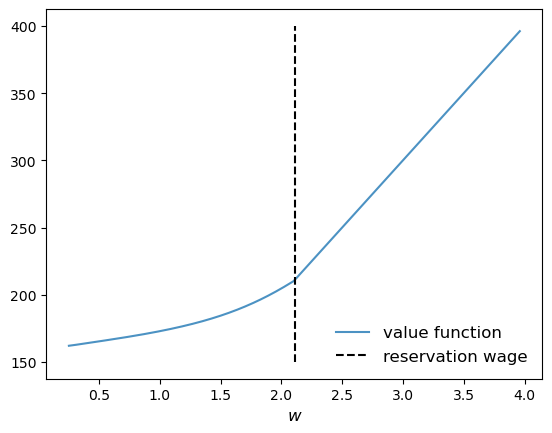

In [30]:
fig, ax = plt.subplots()
ax.plot(w_vals, v_star, alpha=0.8, label="value function")
ax.vlines((res_wage,), 150, 400, 'k', ls='--', label="reservation wage")
ax.legend(frameon=False, fontsize=12, loc="lower right")
ax.set_xlabel("$w$", fontsize=12)
plt.show()

## Exercise

In the setting above, the agent is risk-neutral vis-a-vis future utility risk.

Now solve the same problem but this time assuming that the agent has risk-sensitive
preferences, which are a type of nonlinear recursive preferences.

The Bellman equation becomes

$$
    v(w) = \max
    \left\{
            \frac{w}{1-\beta}, 
            c + \frac{\beta}{\theta}
            \ln \left[ 
                      \sum_{w'} \exp(\theta v(w')) P(w, w')
                \right]
    \right\}
$$


When $\theta < 0$ the agent is risk averse.

Solve the model when $\theta = -0.1$ and compare your result to the risk neutral
case.

Try to interpret your result.

You can start with the following code:

In [20]:
Model = namedtuple('Model', ('n', 'w_vals', 'P', 'β', 'c', 'θ'))

In [21]:
def create_risk_sensitive_js_model(
        n=500,       # wage grid size
        ρ=0.9,       # wage persistence
        ν=0.2,       # wage volatility
        β=0.99,      # discount factor
        c=1.0,       # unemployment compensation
        θ=-0.1       # risk parameter
    ):
    "Creates an instance of the job search model with Markov wages."
    mc = qe.tauchen(n, ρ, ν)
    w_vals, P = jnp.exp(mc.state_values), mc.P
    P = jnp.array(P)
    return Model(n, w_vals, P, β, c, θ)

Now you need to modify `T` and `get_greedy` and then run value function iteration again.

In [22]:
# Put your code here

In [23]:
for i in range(20):
    print("Solution below! 🐾")

Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾


In [24]:
@jax.jit
def T_rs(v, model):
    """
    The Bellman operator Tv = max{e, c + β R v} with 

        e(w) = w / (1-β) and

        (Rv)(w) = (1/θ) ln{E_w[ exp(θ v(W'))]}

    """
    n, w_vals, P, β, c, θ = model
    h = c + (β / θ) * jnp.log(P @ (jnp.exp(θ * v)))
    e = w_vals / (1 - β)

    return jnp.maximum(e, h)


@jax.jit
def get_greedy_rs(v, model):
    " Get a v-greedy policy."
    n, w_vals, P, β, c, θ = model
    e = w_vals / (1 - β)
    h = c + (β / θ) * jnp.log(P @ (jnp.exp(θ * v)))
    σ = jnp.where(e >= h, 1, 0)
    return σ



def vfi(model, max_iter=10_000, tol=1e-4):
    "Solve the infinite-horizon Markov job search model by VFI."
    print("Starting VFI iteration.")
    v = jnp.zeros_like(model.w_vals)    # Initial guess
    i = 0
    error = tol + 1

    while error > tol and i < max_iter:
        new_v = T_rs(v, model)
        error = jnp.max(jnp.abs(new_v - v))
        i += 1
        v = new_v

    v_star = v
    σ_star = get_greedy_rs(v_star, model)
    return v_star, σ_star



model_rs = create_risk_sensitive_js_model()
n, w_vals, P, β, c, θ = model_rs

v_star_rs, σ_star_rs = vfi(model_rs)

Starting VFI iteration.


Let's plot the results together with the original risk neutral case and see what we get.

In [31]:
stop_indices = jnp.where(σ_star_rs == 1)[0]
res_wage_index = stop_indices[0]
res_wage_rs = w_vals[res_wage_index]

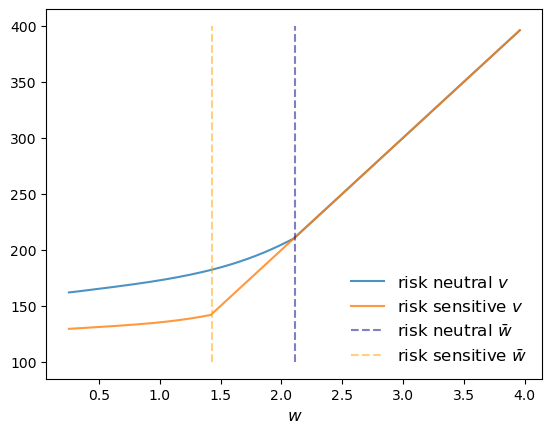

In [32]:
fig, ax = plt.subplots()
ax.plot(w_vals, v_star,  alpha=0.8, label="risk neutral $v$")
ax.plot(w_vals, v_star_rs, alpha=0.8, label="risk sensitive $v$")
ax.vlines((res_wage,), 100, 400,  ls='--', color='darkblue', 
          alpha=0.5, label=r"risk neutral $\bar w$")
ax.vlines((res_wage_rs,), 100, 400, ls='--', color='orange', 
          alpha=0.5, label=r"risk sensitive $\bar w$")
ax.legend(frameon=False, fontsize=12, loc="lower right")
ax.set_xlabel("$w$", fontsize=12)
plt.show()